In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### LOAD DATA

In [42]:
movie = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
IMDb_data = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/IMDB/akas.tsv', sep='\t', dtype={7: str})
IMDb_ratings = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/IMDB/ratings.tsv', sep='\t')
TheMoviesDataset = pd.read_csv('/Users/alielguindi/Desktop/Projects/TheMoviesDataset/movies_metadata.csv')
mojo_int1000 = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/archive/boxofficemojointernationaltop1000.tsv', sep='\t')
mojo_us1000 = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/archive/boxofficemojoustop1000.tsv', sep='\t')
inflation = pd.read_excel('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/Inflation-data.xlsx', sheet_name='hcpi_a')

/var/folders/18/5mg94qls17908xtk_njkwfnr0000gn/T/ipykernel_47032/208108928.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  TheMoviesDataset = pd.read_csv('/Users/alielguindi/Desktop/Projects/TheMoviesDataset/movies_metadata.csv')


In [43]:
# Adding column names
movie_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie box office revenue", "Movie runtime", "Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)"]
character_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"]
plot_summaries_columns = ["Wikipedia movie ID", "Plot summary"]
movie.columns = movie_columns
character.columns = character_columns
plot_summaries.columns = plot_summaries_columns

In [44]:
## PREPARE INFLATION DF

# Considering inflation in the US as a baseline
inflation_us = inflation[inflation['Country Code']=='USA']

# Melt the DataFrame to reshape it
melted_inflation = pd.melt(inflation_us, id_vars=['Country Code', 'IMF Country Code', 'Country', 'Indicator Type', 'Series Name'], var_name='Year', value_name='Inflation')

# Convert the "Year" column to numeric
melted_inflation['Year'] = pd.to_numeric(melted_inflation['Year'], errors='coerce')

melted_inflation = melted_inflation[['Year','Inflation']]

melted_inflation = melted_inflation.iloc[:-2]

# Create a DataFrame with years from 1914 to 1969 and 'inflation' set to 0
additional_years = pd.DataFrame({'Year': range(1914, 1970), 'Inflation': 0})

# Merge the additional_years DataFrame with melted_inflation (Adding 0 inflation to missing years)
melted_inflation = pd.concat([melted_inflation, additional_years], ignore_index=True, sort=False)

# Sort the DataFrame
melted_inflation = melted_inflation.sort_values(by='Year')

# Calculate cumulative inflation to adapt revenues further
melted_inflation['Cumulative Inflation'] = (melted_inflation['Inflation'].astype(float)/100 + 1).cumprod()

display(melted_inflation)

,Year,Inflation,Cumulative Inflation
53,1914.0,0,1.000000
54,1915.0,0,1.000000
55,1916.0,0,1.000000
56,1917.0,0,1.000000
57,1918.0,0,1.000000
...,...,...,...
48,2018.0,2.44,6.849168
49,2019.0,1.812,6.973275
50,2020.0,1.233584,7.059296
51,2021.0,4.697859,7.390932


In [45]:
# Merging movies, actors and ratings
movie_actor = pd.merge(movie, character, how="left", on=["Wikipedia movie ID","Freebase movie ID"])
IMDb_combined = pd.merge(IMDb_data,IMDb_ratings,left_on='titleId',right_on='tconst')
IMDb_combined_mean = IMDb_combined[['title','averageRating']].groupby(['title']).mean()
IMDb_combined_mean.reset_index(inplace=True)
actor_detail_rating = pd.merge(movie_actor,IMDb_combined_mean[['title','averageRating']],left_on='Movie name',right_on='title')

In [46]:
# ADD MISSING BOX OFFICE & RELEASE DATE FROM OTHER DATASETS (Mojo & The Movies Dataset)
# # Date of birth/Gender/Ethnicity (Gender can be determined from name)

# Define a list of datasets to merge
datasets = [
    (TheMoviesDataset, 'original_title', 'revenue','release_date'),
    (mojo_us1000, 'Movie', 'Lifetime Gross','Year'),
    (mojo_int1000, 'Title', 'Worldwide Lifetime Gross','Year')
]

# Remove rows that have revenue = 0
TheMoviesDataset=TheMoviesDataset[TheMoviesDataset['revenue']!=0.0]


# Iterate through the datasets and merge
for dataset, movie_column, revenue_column, date_column in datasets:
    actor_detail_rating = pd.merge(actor_detail_rating, dataset[[movie_column, revenue_column, date_column]], left_on='Movie name', right_on=movie_column, how='left')
    actor_detail_rating['Movie box office revenue'] = actor_detail_rating['Movie box office revenue'].fillna(actor_detail_rating[revenue_column])
    actor_detail_rating['Movie release date_x'] = actor_detail_rating['Movie release date_x'].fillna(actor_detail_rating[date_column])
    actor_detail_rating = actor_detail_rating.drop([revenue_column,date_column], axis=1)

In [47]:
# Handle Nan Values 
# Convert Nans to 0
actor_detail_rating['Movie box office revenue'] = actor_detail_rating['Movie box office revenue'].fillna(0)
# # Remove rows with Box office = Nan
# actor_detail_rating.dropna(subset='Movie box office revenue', inplace=True)

In [48]:
# ADAPT BOX OFFICE REVENUE WITH INFLATION
actor_detail_rating['Year'] = actor_detail_rating['Movie release date_x'].str.extract(r'(\d{4})').astype(float)
actor_detail_rating_inflation = pd.merge(actor_detail_rating,melted_inflation[['Year','Cumulative Inflation']])

actor_detail_rating_inflation['Adapted Movie box office revenue'] = actor_detail_rating_inflation['Movie box office revenue']/actor_detail_rating_inflation['Cumulative Inflation']
display(actor_detail_rating_inflation)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date_x,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release date_y,...,Freebase character ID,Freebase actor ID,title,averageRating,original_title,Movie,Title,Year,Cumulative Inflation,Adapted Movie box office revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgchn4,/m/0346l4,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgchn_,/m/01vw26l,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgchnq,/m/034hyc,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgchp9,/m/01y9xg,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454170,28253090,/m/0cn_phk,Altitude,2017-04-14,0.0,NaN,{},{},"{""/m/03npn"": ""Horror""}",NaN,...,NaN,/m/03g_fm7,Altitude,4.672727,Altitude,NaN,NaN,2017.0,6.686029,0.000000e+00
454171,28253090,/m/0cn_phk,Altitude,2017-04-14,0.0,NaN,{},{},"{""/m/03npn"": ""Horror""}",NaN,...,NaN,/m/0265twh,Altitude,4.672727,Altitude,NaN,NaN,2017.0,6.686029,0.000000e+00
454172,28253090,/m/0cn_phk,Altitude,2017-04-14,0.0,NaN,{},{},"{""/m/03npn"": ""Horror""}",NaN,...,NaN,/m/047lf34,Altitude,4.672727,Altitude,NaN,NaN,2017.0,6.686029,0.000000e+00
454173,36040597,/m/0gkrxgx,Bitter Harvest,2017-02-23,557241.0,98.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/05p553"": ""Comedy...",NaN,...,NaN,NaN,Bitter Harvest,6.307407,Bitter Harvest,NaN,NaN,2017.0,6.686029,8.334409e+04


### FAME


In [49]:
# Conserve relevant columns
columns_to_conserve = ['Actor name', 'Movie name', 'Movie release date_y', 'averageRating', 'Adapted Movie box office revenue']
conserved_df = actor_detail_rating_inflation[columns_to_conserve].copy()
conserved_df['Year'] = conserved_df['Movie release date_y'].str.extract('(\d{4})')
conserved_df.columns = ['Actor Name', 'Movie name', 'Date', 'Rating', 'Revenue', 'Year']
conserved_df = conserved_df.groupby(['Actor Name', 'Movie name', 'Year'], as_index=False).agg({
    'Rating': 'mean',
    'Revenue': 'mean'
})

conserved_df = conserved_df.sort_values(by='Year', ascending=False)

display(conserved_df)

,Actor Name,Movie name,Year,Rating,Revenue
301592,Ray Wise,Jeepers Creepers 4,2016,2.500000,0.0
235916,Marieh Delfino,Jeepers Creepers 4,2016,2.500000,0.0
225826,Luke Edwards,Jeepers Creepers 4,2016,2.500000,0.0
43106,Brandon Smith,Jeepers Creepers 4,2016,2.500000,0.0
125939,Gina Philips,Jeepers Creepers 4,2016,2.500000,0.0
...,...,...,...,...,...
241901,Mary Pickford,Tess of the Storm Country,1914,6.236364,0.0
38334,Billy Bowers,The Fresh Air Cure,1914,4.400000,0.0
225479,Luis García Lawson,Amalia,1914,6.500000,0.0
97685,Edward Abeles,Brewster's Millions,1914,6.708696,22916566.0


In [50]:
## 0TH STEP: REMOVE ACTORS WHO HAVE LESS THAN 10 MOVIES IN THE DF
actor_movie_counts = conserved_df['Actor Name'].value_counts()
actors_with_10_or_more_movies = actor_movie_counts[actor_movie_counts >= 10].index
filtered_df = conserved_df[conserved_df['Actor Name'].isin(actors_with_10_or_more_movies)]

In [51]:
## 1ST STEP: RANKIZE RATING AND REVENUE
columns_to_scale = ['Revenue', 'Rating']
actor_popularity_rank = filtered_df.copy()
ranks = filtered_df[columns_to_scale].rank()
# normalized_ranks to be between 0 and 1
normalized_ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
actor_popularity_rank[columns_to_scale] = normalized_ranks
actor_popularity_rank = actor_popularity_rank.sort_values(by='Year', ascending=False)

display(actor_popularity_rank)

,Actor Name,Movie name,Year,Rating,Revenue
301592,Ray Wise,Jeepers Creepers 4,2016,0.001981,0.0
43106,Brandon Smith,Jeepers Creepers 4,2016,0.001981,0.0
125939,Gina Philips,Jeepers Creepers 4,2016,0.001981,0.0
225826,Luke Edwards,Jeepers Creepers 4,2016,0.001981,0.0
339541,Sigourney Weaver,Avatar 2,2015,0.942102,0.0
...,...,...,...,...,...
91310,Donald Crisp,The Battle of the Sexes,1914,0.561757,0.0
227827,Mack Swain,Tillie's Punctured Romance,1914,0.607977,0.0
39812,Blanche Sweet,Judith of Bethulia,1914,0.397739,0.0
275593,Oliver Hardy,The Fresh Air Cure,1914,0.043825,0.0


In [52]:
## 2ND STEP: COMPUTE ACTOR FAME COEFFICIENT FOR A CERATAIN MOVIE IN A CERTAIN YEAR
columns_to_scale = ['Revenue', 'Rating']
weights = [4, 1]  # Adjust weights based on your preference
actor_popularity_movie_coef = actor_popularity_rank
# Calculate weighted average of normalized rating and normalized revenue
actor_popularity_movie_coef['Fame Coefficient'] = np.average(actor_popularity_rank[columns_to_scale], axis=1, weights=weights)

actor_popularity_movie_coef = actor_popularity_movie_coef.sort_values(by='Fame Coefficient',ascending=False)

display(actor_popularity_movie_coef)

,Actor Name,Movie name,Year,Rating,Revenue,Fame Coefficient
373987,Viggo Mortensen,The Lord of the Rings: The Return of the King,2003,0.998587,0.998348,0.998396
144494,Ian McKellen,The Lord of the Rings: The Return of the King,2003,0.998587,0.998348,0.998396
47023,Bruce Spence,The Lord of the Rings: The Return of the King,2003,0.998587,0.998348,0.998396
144322,Ian Holm,The Lord of the Rings: The Return of the King,2003,0.998587,0.998348,0.998396
288236,Peter Jackson,The Lord of the Rings: The Return of the King,2003,0.998587,0.998348,0.998396
...,...,...,...,...,...,...
26395,Arun Bakshi,Desh Drohi,2008,0.000035,0.000000,0.000007
272501,Nirmal Pandey,Desh Drohi,2008,0.000035,0.000000,0.000007
386161,Yashpal Sharma,Desh Drohi,2008,0.000035,0.000000,0.000007
183971,Jonathan Banks,Proud American,2008,0.000005,0.000000,0.000001


In [53]:
### 3RD STEP: COMPUTE SUM OF ACTOR FAME COEFFICIENT FOR A CERTAIN YEAR (OVER THE MOVIES OF THIS YEAR)
actor_movie_year = actor_popularity_movie_coef.groupby(['Actor Name', 'Year'])['Fame Coefficient'].sum().reset_index()
actor_movie_year = actor_movie_year[actor_movie_year['Year'] >= '1914']
actor_movie_year['Year'] = actor_movie_year['Year'].replace('1010', '2010')

actor_movie_year = actor_movie_year.sort_values(by='Year',ascending=True)

display(actor_movie_year)

,Actor Name,Year,Fame Coefficient
82162,Paul Panzer,1914,0.153736
27871,Earle Fox,1914,0.174241
46317,Jan van Dommelen,1914,0.057202
44004,Jack Richardson,1914,0.264599
40471,Henry B. Walthall,1914,0.309211
...,...,...,...
99539,Sigourney Weaver,2015,0.188420
12117,Brandon Smith,2016,0.000396
66020,Luke Edwards,2016,0.000396
36910,Gina Philips,2016,0.000396


In [54]:
## CHECKING FOR CORRECTNESS WITH Željko Ivanek IN 2012
zelko_ivanek_df = actor_popularity_movie_coef[(actor_popularity_movie_coef['Actor Name'] == 'Željko Ivanek') & (actor_popularity_movie_coef['Year'] == '2012')]
display(zelko_ivanek_df)

,Actor Name,Movie name,Year,Rating,Revenue,Fame Coefficient
391054,Željko Ivanek,Argo,2012,0.930425,0.823755,0.845089
391068,Željko Ivanek,Seven Psychopaths,2012,0.816682,0.639935,0.675284
391075,Željko Ivanek,The Words,2012,0.801698,0.634875,0.668240


In [55]:
## 4TH STEP: CREATE DATAFRAME WITH FAME COEFFICIENT FOR EACH ACTOR EACH YEAR
# Create a DataFrame with all actor-year combinations from 1914 to 2012
years = list(range(1914, 2013))
actors = actor_movie_year['Actor Name'].unique()
actor_year_combinations = pd.MultiIndex.from_product([actors, years], names=['Actor Name', 'Year']).to_frame(index=False)
actor_year_combinations.columns = ['Actor Name', 'Year']
actor_year_combinations['Year'] = actor_year_combinations['Year'].astype(str)

# Merge the actor_year_combinations DataFrame with actor_movie_year to get the coefficients
all_actor_year = pd.merge(actor_year_combinations, actor_movie_year, on=['Actor Name', 'Year'], how='left')

# Fill missing values in the 'Fame Coefficient' column with 0
all_actor_year['Fame Coefficient'].fillna(0, inplace=True)

# Rename 'Fame Coefficient' to 'Actor Year Coefficient'
all_actor_year.rename(columns={'Fame Coefficient': 'Fame Coefficient'}, inplace=True)

# Sort the result DataFrame
all_actor_year = all_actor_year.sort_values(by=['Year', 'Actor Name'], ascending=[True, True])

# Reset the index
all_actor_year.reset_index(drop=True, inplace=True)

display(all_actor_year)

,Actor Name,Year,Fame Coefficient
0,50 Cent,1914,0.000000
1,A Martinez,1914,0.000000
2,A. J. Buckley,1914,0.000000
3,A. J. Cook,1914,0.000000
4,A.K Hangal,1914,0.000000
...,...,...,...
819319,Zoë Kravitz,2012,0.000000
819320,Zsa Zsa Gábor,2012,0.000000
819321,Ángela Molina,2012,0.000000
819322,Édith Scob,2012,0.573440


In [56]:
## 5TH STEP: FOR FAME THROUGH YEARS: ADD A CONTRIBUTION OF THE FAME COEFFICIENT OF THE PREVIOUS YEARS
previous_year_contribution = 0.7

actor_year_df = all_actor_year.copy()
actor_year_df.sort_values(by=['Actor Name', 'Year'], inplace=True)

# Initialize a dictionary to store the previous 'Coefficient with Past' values for each actor
prev_b_values = {}

# Iterate through the rows of the DataFrame to compute the values for column B
for index, row in actor_year_df.iterrows():
    actor = row['Actor Name']
    year = row['Year']
    a_value = row['Fame Coefficient']
    
    if actor in prev_b_values:
        b_value = a_value + previous_year_contribution * prev_b_values[actor]
    else:
        b_value = a_value  # If there is no previous value, use A(actor, year) as-is
    
    actor_year_df.at[index, 'Coefficient with Past'] = b_value
    prev_b_values[actor] = b_value

actor_year_df['Year'] = pd.to_numeric(actor_year_df['Year'])

# Display the first few rows of the result DataFrame
display(actor_year_df)

,Actor Name,Year,Fame Coefficient,Coefficient with Past
0,50 Cent,1914,0.000000,0.000000
8276,50 Cent,1915,0.000000,0.000000
16552,50 Cent,1916,0.000000,0.000000
24828,50 Cent,1917,0.000000,0.000000
33104,50 Cent,1918,0.000000,0.000000
...,...,...,...,...
786219,Željko Ivanek,2008,0.799468,2.568668
794495,Željko Ivanek,2009,0.000000,1.798067
802771,Željko Ivanek,2010,0.000000,1.258647
811047,Željko Ivanek,2011,0.000000,0.881053


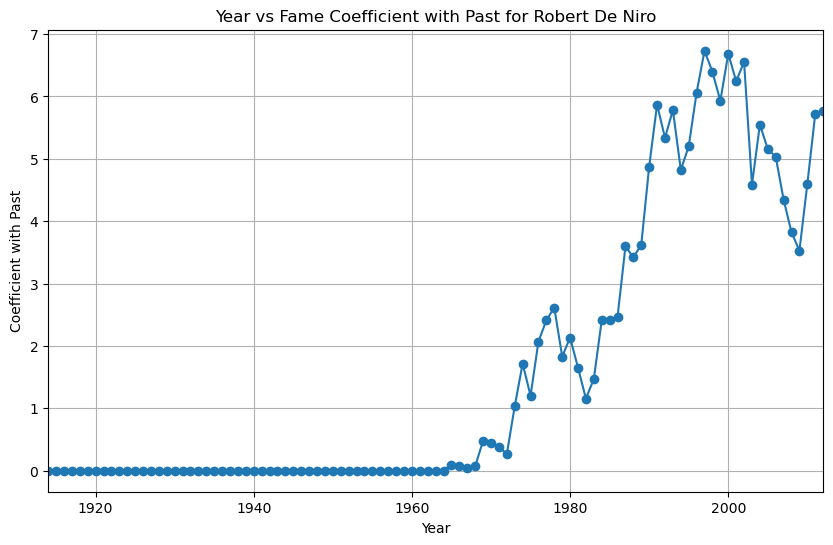

In [57]:
## PLOT FAME OF PARTICULAR ACTOR
actor_name = 'Robert De Niro' #'Steven Spielberg'# # PUT NAME HERE

particular_actor_df = actor_year_df[actor_year_df['Actor Name'] == actor_name]

plt.figure(figsize=(10, 6))
years = particular_actor_df['Year']
coefficients = particular_actor_df['Coefficient with Past']

plt.xlim(1914, 2012)
plt.plot(years, coefficients, marker='o', linestyle='-')
plt.title('Year vs Fame Coefficient with Past for ' + actor_name)
plt.xlabel('Year')
plt.ylabel('Coefficient with Past')
plt.grid(True)

plt.show()

### GENERAL FAME    

In [58]:
general_fame = actor_year_df.groupby(['Actor Name'])['Fame Coefficient'].sum().reset_index()
general_fame = general_fame.sort_values(by='Fame Coefficient',ascending=False)
display(general_fame)
# general_fame.head(n=20)

,Actor Name,Fame Coefficient
5216,Mel Blanc,63.779095
6961,Samuel L. Jackson,60.242138
6622,Robert De Niro,53.144437
990,Bruce Willis,50.063660
3796,John Goodman,45.367969
...,...,...
3440,Jayam Ravi,0.290555
4043,Julie Ege,0.260068
5377,Michelle Bauer,0.235044
6454,Rhett Giles,0.063575


### FAME EVOLUTION

In [59]:
# fame_start_end_threshold will be defined
fame_start_end_threshold = 0.2
filtered_actor_year_df = actor_year_df[actor_year_df['Coefficient with Past'] > fame_start_end_threshold]
grouped = filtered_actor_year_df.groupby('Actor Name').agg({'Year': ['min', 'max']})
grouped = grouped.reset_index()
grouped.columns = ['Actor Name', 'First Year', 'Last Year']  # Rename the columns

result_df = grouped.copy()  # Create a copy of grouped DataFrame

result_df['Range'] = result_df['Last Year'] - result_df['First Year']
result_df = result_df.sort_values(by='First Year')
result_df['First Year'] = pd.to_numeric(result_df['First Year'])
result_df['Last Year'] = pd.to_numeric(result_df['Last Year'])
result_df['Range'] = pd.to_numeric(result_df['Range'])


display(result_df)

,Actor Name,First Year,Last Year,Range
1213,Charlie Chaplin,1914,1976,62
5538,Murdock MacQuarrie,1914,1940,26
6628,Robert Harron,1914,1922,8
2878,Harry von Meter,1914,1927,13
4695,"Lon Chaney, Sr.",1914,1937,23
...,...,...,...,...
4670,Livingston,2011,2011,0
562,Asif Ali,2011,2012,1
4456,Larry Day,2012,2012,0
7935,Vimala Raman,2012,2012,0


In [60]:
result_df.head(n=20)

,Actor Name,First Year,Last Year,Range
1213,Charlie Chaplin,1914,1976,62
5538,Murdock MacQuarrie,1914,1940,26
6628,Robert Harron,1914,1922,8
2878,Harry von Meter,1914,1927,13
4695,"Lon Chaney, Sr.",1914,1937,23
8016,Wallace MacDonald,1914,1929,15
2172,Elmo Lincoln,1914,1930,16
1243,Chester Conklin,1914,1945,31
1219,Charlotte Burton,1914,1919,5
1212,Charley Chase,1914,1934,20


In [61]:
filtered_actor_year_df = result_df.sort_values(by='First Year')
grouped_years = filtered_actor_year_df.groupby('First Year')['Range'].mean().reset_index()

display(grouped_years)

,First Year,Range
0,1914,26.758621
1,1915,27.444444
2,1916,23.136364
3,1917,28.400000
4,1918,18.571429
...,...,...
94,2008,3.945946
95,2009,2.904762
96,2010,2.000000
97,2011,0.500000


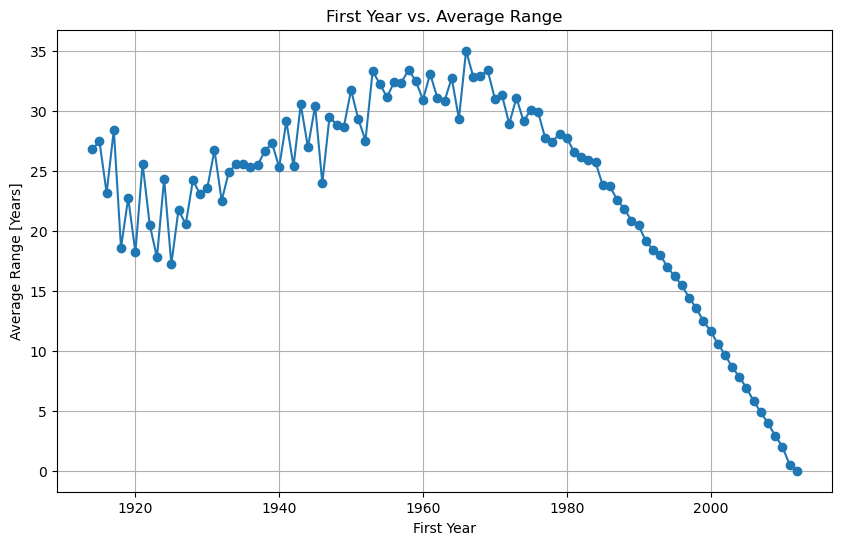

In [62]:
filtered_actor_year_df = result_df.sort_values(by='First Year')
grouped_years = filtered_actor_year_df.groupby('First Year')['Range'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(grouped_years['First Year'], grouped_years['Range'], marker='o', linestyle='-')
plt.title('First Year vs. Average Range')
plt.xlabel('First Year')
plt.ylabel('Average Range [Years]')
plt.grid(True)
plt.show()

### UNUESED BUT MIGHT BE USED 

In [63]:
## REMOVED 6TH STEP BUT MIGHT BE USEFUL LATER
## 6TH STEP: REMOVE ACTORS WHO HAVE HAD SUCCESS BEFORE 1924 OR AFTER 2002
## THIS ALLOWS US TO REMOVE ACTORS WHO MIGHT STARTED ACTING BEFORE THE DATASET OR WHO CONTINUED ACTING AFTER
mask = actor_year_df[(actor_year_df['Year'] >= 2002) & (actor_year_df['Coefficient with Past'] > 0.1)]
actors_to_remove = mask['Actor Name'].unique()
filtered_actor_year_df = actor_year_df[~actor_year_df['Actor Name'].isin(actors_to_remove)]

mask = actor_year_df[(actor_year_df['Year'] <= 1924) & (actor_year_df['Coefficient with Past'] > 0.1)]
actors_to_remove = mask['Actor Name'].unique()
filtered_actor_year_df = filtered_actor_year_df[~actor_year_df['Actor Name'].isin(actors_to_remove)]
filtered_actor_year_df.reset_index(drop=True, inplace=True)

display(filtered_actor_year_df)

/var/folders/18/5mg94qls17908xtk_njkwfnr0000gn/T/ipykernel_47032/2581459468.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_actor_year_df = filtered_actor_year_df[~actor_year_df['Actor Name'].isin(actors_to_remove)]


,Actor Name,Year,Fame Coefficient,Coefficient with Past
0,Aarti,1914,0.0,0.000000
1,Aarti,1915,0.0,0.000000
2,Aarti,1916,0.0,0.000000
3,Aarti,1917,0.0,0.000000
4,Aarti,1918,0.0,0.000000
...,...,...,...,...
248485,Zero Mostel,2008,0.0,0.000026
248486,Zero Mostel,2009,0.0,0.000018
248487,Zero Mostel,2010,0.0,0.000013
248488,Zero Mostel,2011,0.0,0.000009


In [67]:
filtered_actor_year_df

,Actor Name,Year,Fame Coefficient,Coefficient with Past
0,Aarti,1914,0.0,0.000000
1,Aarti,1915,0.0,0.000000
2,Aarti,1916,0.0,0.000000
3,Aarti,1917,0.0,0.000000
4,Aarti,1918,0.0,0.000000
...,...,...,...,...
248485,Zero Mostel,2008,0.0,0.000026
248486,Zero Mostel,2009,0.0,0.000018
248487,Zero Mostel,2010,0.0,0.000013
248488,Zero Mostel,2011,0.0,0.000009


### Further analyis using the fame coeffecient and the other actors 

In [117]:
# Reading the characters metadata for subsequent analysis with the general fame
characters = pd.read_csv('/Users/alielguindi/Desktop/Projects/ada-2023-project-pandateam23/MovieSummaries/character.metadata.tsv', sep = '\t', names=["wikipedia_movie_id", "freebase_movie_id", "movie_dor", "character_name", "actor_dob",
                                "actor_gender", "actor_height", "actor_ethnicity", "actor_name",
                                "actor_age_release", "freebase_character_map", "freebase_character_id", "freebase_actor_id"],
                         header=None)
characters = characters[characters['actor_name'].notna()]

In [118]:
# Merging both dataframes to get the general fame of the actors with the charcaters metadata
#Merging on actor_name with an inner join to get only actors that are present in both dataframes
#Rename the column for the merging 
general_fame.rename(columns = {'Actor Name' : 'actor_name'}, inplace = True)
characters_fame = pd.merge(characters, general_fame, on = 'actor_name', how = 'inner')

### The characters_fame dataframe is the one for wich we will do our anylsis

In [119]:
#Sanity check to see if Fame coeffecient does not contain any NaN values 
print('Number of NaN values in the Fame coeffecient column is : {}'.format(characters_fame['Fame Coefficient'].isna().sum()))

Number of NaN values in the Fame coeffecient column is : 0


In [133]:
# Based on our research, we know that year = 1010 corresponds to year 2010. 
# We change that in the dataframe
characters_fame['movie_dor'] = characters['movie_dor'].astype(str).apply(lambda x : x.replace('1010','2010'))

# Creating a new column for storing only the year of the movie release 
characters_fame['movie_year'] = characters['movie_dor'].str[:4]

characters_fame['movie_year'] = characters_fame['movie_year'].astype(int)

In [135]:
#Taking years after 1910
characters_fame = characters_fame[characters_fame['movie_year'] > 1910]


### Now focusing on the proportion of each sex in the industry

In [136]:
# Grouping by the sex to see the proportion of each of them.
characters_female = characters_fame.groupby(['movie_year']).apply(lambda x: len(x[x['actor_gender'] == 'F']))
characters_male = characters_fame.groupby(['movie_year']).apply(lambda x: len(x[x['actor_gender'] == 'M']))
characters_female_perc = (characters_female / (characters_female + characters_male)) * 100.0
characters_male_perc = (characters_male / (characters_female + characters_male)) * 100.0


In [137]:
#Descriptive statistics for women proportion wrt to men
characters_female_perc.describe()

count    105.000000
mean      29.775738
std        5.718380
min        5.555556
25%       27.586207
50%       29.712460
75%       31.908964
max       63.636364
dtype: float64

In [138]:
#Descriptive statistics for women proportion wrt to men
characters_male_perc.describe()

count    105.000000
mean      70.224262
std        5.718380
min       36.363636
25%       68.091036
50%       70.287540
75%       72.413793
max       94.444444
dtype: float64

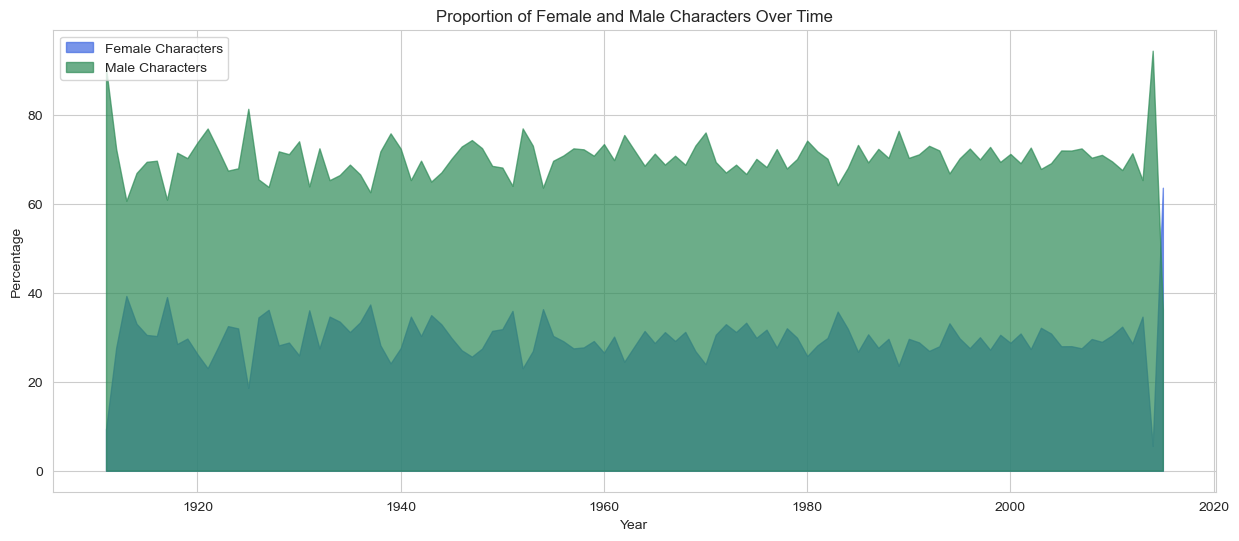

In [158]:
# Visualizing the proportions on the stacked area chart
# Prepare data for plotting
years = characters_female_perc.index
female_perc = characters_female_perc.values
male_perc = characters_male_perc.values

fig, ax = plt.subplots(figsize=(15, 6))

# Plot the stacked area chart with more contrasting colors and transparency
ax.fill_between(years, female_perc, label='Female Characters', color='royalblue', alpha=0.7)
ax.fill_between(years, male_perc, label='Male Characters', color='seagreen', alpha=0.7)

# Adding labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Proportion of Female and Male Characters Over Time')

# Add a legend to the plot
ax.legend(loc='upper left')

# Display the plot
plt.show()




### Analysis :  the Fame for each of the sex

In [200]:
#Getting fame coeffecient for male and female 
fame_male = characters_fame.loc[characters_fame['actor_gender'] == 'M']['fame_coefficient']
fame_female = characters_fame.loc[characters_fame['actor_gender'] == 'F']['fame_coefficient']

In [ ]:
#Descriptive statistic for male fame coeffecient
fame_male.describe()

count    142963.000000
mean         10.655017
std           9.685339
min           0.047797
25%           3.903116
50%           7.473013
75%          14.494165
max          63.779095
Name: Fame Coefficient, dtype: float64

In [ ]:
#Descriptive statistic for female fame coeffecient
fame_female.describe()

count    59945.000000
mean         7.766381
std          6.265177
min          0.235044
25%          3.215664
50%          5.674584
75%         10.568041
max         39.883912
Name: Fame Coefficient, dtype: float64

Text(0.5, 1.0, 'Distrubtion of fame coeffecient for Female actors')

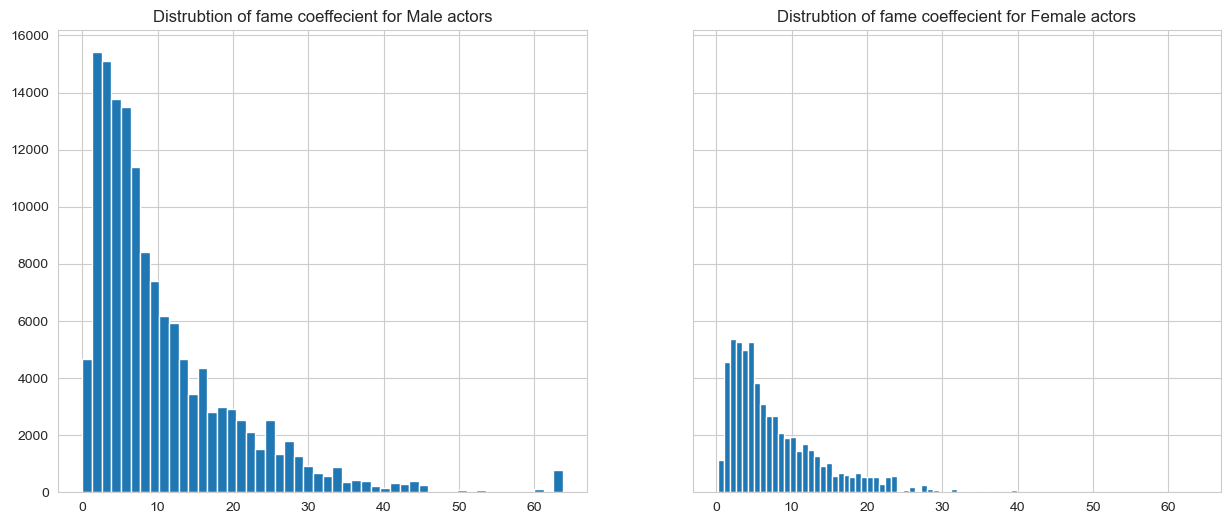

In [ ]:
#Histogram to get a sense of the distribution of fame for both men and women
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True,sharex = True)
# Plot the cleaned data with Seaborn
axs[0].hist(fame_male, bins= 50)
axs[0].set_title('Distrubtion of fame coeffecient for Male actors')

axs[1].hist(fame_female, bins= 50)
axs[1].set_title('Distrubtion of fame coeffecient for Female actors')


Notes about the histograms : 
* Both male and female actors generally have lower fame coefficients, but males show a wider range of values.
* The distributions are right-skewed, indicating more actors are at the lower fame end, with few exceptionally high values.
* Male actors have a longer tail in their distribution, suggesting a higher occurrence of very famous actors compared to females.
* The presence of outliers, especially among male actors, suggests some have much higher fame coefficients than other male actors.
* These observed patterns could affect statistical assumptions, like normality, in regression models.

In [ ]:
# We perform a hypothesis testing to compare the means of fame for male and female
# Assumption : Fame coefficients are normally distributed for the test (which is not the case by just observing the histograms)
import scipy.stats as stats
stats.ttest_ind(fame_male.values, fame_female)



TtestResult(statistic=67.35209685978697, pvalue=0.0, df=202906.0)

* We take our significance level $\alpha = 0.05$ 
* $H_0 : \mu_{male} = \mu_{female}$
* $H_1 : \mu_{male} \neq \mu_{female}$
* p is smaller than 0.05 -> we reject the null hypothesis that the fame coeffecient is the same -> there is statstically significant difference.
* However, as seen in the lectures,  rejecting the null hypothesis doesn't necessarily prove the alternative hypothesis.


Simple linear Regression : with the fame coefficient as the dependent variable and gender (categorical) as the independent variable.
For just the sake of  quantifying the change in the fame coefficient associated with being male versus female.

In [199]:
import statsmodels.formula.api as smf

import statsmodels.formula.api as smf


#Renaming the column Fame Coefficient to fame_coefficient
characters_fame.rename(columns = {'Fame Coefficient' : 'fame_coefficient'}, inplace = True)

# Correcting the formula with backticks for the column name with space
mod = smf.ols(formula='fame_coefficient ~ C(actor_gender)', data=characters_fame)

# Fit the model
results = mod.fit()

# View the results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:       fame_coefficient   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4536.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:29:37   Log-Likelihood:            -7.2951e+05
No. Observations:              202908   AIC:                         1.459e+06
Df Residuals:                  202906   BIC:                         1.459e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.7664 

* Some notes about the model :
* Very simple Model
* Both coeffecients are statistically significant
* Intercept : The average fame rating for female actors is about 7.77, and this finding is statistically significant.
* Coeffecient for male actors : Male actors tend to have a fame score that is about 2.89 points higher than female actors, and this difference is statistically significant.
* R-squared: 0.022, meaning that approximately 2.2% of the variance in fame_coefficient is explained by the model. This is a relatively low value
* Consistency with the histograms plotted before.

### Actor appearence and fame coeffecient 

In [201]:
# Separate male and female actors
male_actors = characters_fame[characters_fame['actor_gender'] == 'M']
female_actors = characters_fame[characters_fame['actor_gender'] == 'F']

# Group by 'freebase_actor_id' and calculate the minimum age at release for male and female actors separately
min_age_male_actors = male_actors.groupby('freebase_actor_id')['actor_age_release'].min()
min_age_female_actors = female_actors.groupby('freebase_actor_id')['actor_age_release'].min()

In [202]:
# Some values are negative, which is impossible
# Let's see how many negative values we have
negative_val_male = (min_age_male_actors.values < 0).sum()
negative_val_female = (min_age_female_actors.values < 0).sum()
negative_val_male

print('We have {} negative first appearance for male actors'.format(negative_val_male))
print('We have {} negative first appearance for female actors'.format(negative_val_female))
 

We have 49 negative first appearance for male actors
We have 29 negative first appearance for female actors


In [223]:
# We should be cleaning the data to avoid negative values becaus it is not possible.
min_age_male_actors =min_age_male_actors[~(min_age_male_actors.values < 0)]
min_age_female_actors =min_age_female_actors[~(min_age_female_actors.values < 0)]

count    2470.000000
mean       22.125506
std         7.921268
min         0.000000
25%        18.000000
50%        22.000000
75%        26.000000
max        73.000000
Name: actor_age_release, dtype: float64

Text(0.5, 1.0, 'Boxplot of female first appearance age')

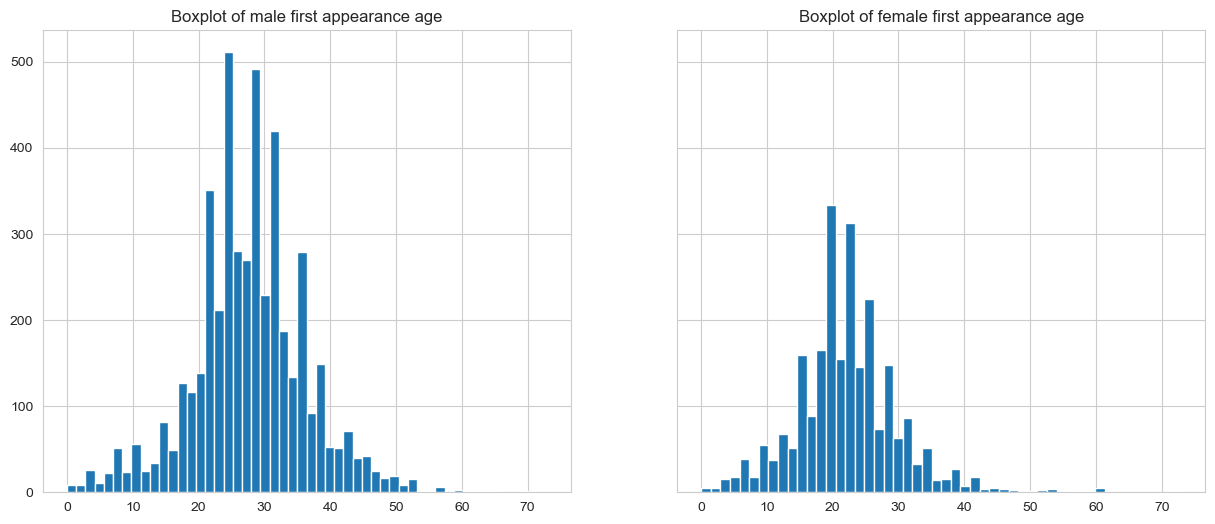

In [230]:
#Histogram for female and male actors -> min_age_male_actors, min_age_female_actors
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True,sharex = True)
# Plot the cleaned data with Seaborn
axs[0].hist(min_age_male_actors.tolist(), bins = 50)
axs[0].set_title('Boxplot of male first appearance age')

axs[1].hist(min_age_female_actors.tolist(), bins = 50)
axs[1].set_title('Boxplot of female first appearance age')





* Notes about the histograms : 
* The most common age for actors to start their careers is in their early twenties for both genders.
* There are child actors in the industry, as indicated by the occurrences of first appearances from very young ages, though they are less common.
* The likelihood of actors starting their careers decreases with age, showing fewer first appearances as age increases.
* The overall patterns and trends in the age of first appearance are similar for male and female actors, suggesting no significant gender differences in starting ages within the industry.

In [244]:
# We should eliminate NaN values to perform a t-test 
min_age_male_actors.dropna(inplace=True)
min_age_female_actors.dropna(inplace=True)

# We perform a hypothesis testing to compare the means of fame for male and female
# Assumption : Fame coefficients are normally distributed for the test
import scipy.stats as stats
stats.ttest_ind(min_age_male_actors.values, min_age_female_actors.values)

TtestResult(statistic=26.297839886015844, pvalue=1.2482804361374884e-145, df=7214.0)

The p-value is far below the common alpha level of 0.05 (even 0.01 or 0.001), which suggests that the difference in the age of appearance between the two groups being compared is statistically significant

In [245]:
# Scatter plot with fame coefficient and age of first appearance for female and male actors
#Two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True,sharex = True)
# Plot the cleaned data with Seaborn



freebase_actor_id
/m/011_3s    37.0
/m/011zd3    26.0
/m/012_53    19.0
/m/012cyp    17.0
/m/012czd    22.0
             ... 
/m/0qdgc     22.0
/m/0qksf     16.0
/m/0sw5n     24.0
/m/0sw62     25.0
/m/0sw6y     37.0
Name: actor_age_release, Length: 2470, dtype: float64

In [249]:
###### Do a scatter plot if Nicolas can get us the data for each actor's first appearance age

##### Do a regression  (regress fame_coefficient on age)

##### Do a correlation 

### If we have all values

142963
4746
